
##  1. The following cell contains the libraries needed for calculation

In [2]:
import numpy as np
import pandas as pd

from pylife.stress.histogram import *
import pylife.stress.timesignal as ts
from pylife.stress.rainflow import *
import pylife.stress.equistress

import pylife.strength.meanstress
from pylife.strength import miner
from pylife.strength import sn_curve
from pylife.strength.miner import MinerElementar, MinerHaibach
from pylife.strength import failure_probability as fp

from pylife.materialdata.woehler.diagrams.woehler_curve_diagrams import WoehlerCurveDiagrams

import pylife.mesh.meshplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl

from scipy.stats import norm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import io
from IPython.display import HTML
import base64

# mpl.style.use('seaborn')
# mpl.style.use('seaborn-notebook')
mpl.style.use('bmh')
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# 2. Time series signal

1. The argument 'index' contains the name of the rows
2. The argument 'column' contains the name of the columns
3. The argument 'data' contains the data belonging to the column

 For importing data using pandas Dataframe check out the file named 'pandas.ipynb'

In [3]:


t = np.linspace(0,60,60*2048)  # Numbers between 0 and 60  divided into 60*2048 intervals 
files = ['wn','sine']          # 2048 is the frequency fo the wave data generated here


wn = pd.DataFrame(index = t, columns = ['sensor_1'], data = 120*np.random.randn(len(t))) #To create a dataset with t as the name of the rows and data as the sensor_1 column 
sine = pd.DataFrame(index = t, columns = ['sensor_1'], data = 80*np.sin(2*np.pi*50*t))

input_data = [wn,sine]         # List which contains both wn and sine dataset so the length is 2
  

    
print(len(input_data))  
wn

2


sensor_1
0.000000   -88.992506
0.000488  -151.294154
0.000977  -235.897046
0.001465  -120.502457
0.001953    72.074770
...               ...
59.998047  -37.767988
59.998535  250.155352
59.999023   69.533072
59.999512  -24.143920
60.000000  124.515164

[122880 rows x 1 columns]

# 3. Resampling

Here widget function has been used to create an interactive GUI which asks user's input for resampling frequency. For examples check the file widgets.ipynb

In [4]:

    # Float text widget with minimum value of 1 and maximum value of 100000 #
f_resample = widgets.FloatText(value = 1024,min=1,max=100e3,step=1,description='Resampling frequency [Hz]',
    disabled=False,readout=True,readout_format='d')
display(f_resample)




FloatText(value=1024.0, description='Resampling frequency [Hz]', step=1.0)

The following cell resamples the data of frequency 2048 Hz to the frequency specified by user input in the above widget

In [5]:
meas_resample = []
for file_act in input_data:
    #  Function for resampling the dataset of specified frequency #
    meas_resample.append(ts.TimeSignalPrep(file_act).resample_acc(f_resample.value))

meas_resample

[             sensor_1
 0.000000   -88.992506
 0.000977  -235.895669
 0.001953    72.068501
 0.002930    78.794144
 0.003906  -263.497277
 ...               ...
 59.996094  122.951293
 59.997070   84.954584
 59.998047  -37.758615
 59.999023   69.531547
 60.000000  124.515164
 
 [61441 rows x 1 columns],
                sensor_1
 0.000000   0.000000e+00
 0.000977   2.416047e+01
 0.001953   4.606464e+01
 0.002930   6.366692e+01
 0.003906   7.532347e+01
 ...                 ...
 59.996094 -7.532347e+01
 59.997070 -6.366692e+01
 59.998047 -4.606464e+01
 59.999023 -2.416047e+01
 60.000000 -8.152041e-11
 
 [61441 rows x 1 columns]]

The following cell creates a widget which asks for user input on which sensor data to plot

In [6]:

print("select channel to plot")
plotChan = widgets.Dropdown(options = file_act.columns)  # Dropdown widget function #
display(plotChan)



select channel to plot


Dropdown(options=('sensor_1',), value='sensor_1')

The following cell plots the data set (signal) of the chosen channel. It utilizes matplotlib function for plotting dataset

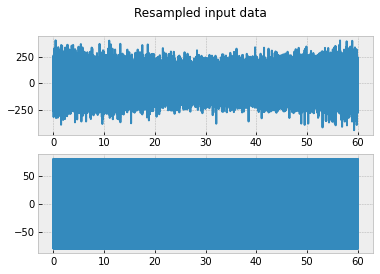

In [7]:


fig, ax = plt.subplots(len(meas_resample))  # Matplotlib function for creating plots
fig.suptitle('Resampled input data')        # For creating title name
ii = 0


#  Plots the value of index against the sensor data #
for df_act in meas_resample:    
    if len(meas_resample) == 1:
        ax.plot(df_act.index, df_act[plotChan.value])   #df_act.index will have the index values and df_act(plotchan:value) will have the sensor data
    
    #For creating more than one plot
    else:
        ax[ii].plot(df_act.index, df_act[plotChan.value]) 
    ii += 1
    plt.savefig('Resampling.png')


# 4. Fitering

Filtering the time series with a bandpass filter.

The following cell creates two Floattext widget for mentioning min and max frequency for bandpass filter

In [8]:
f_min = widgets.FloatText(value = 5,description='min frequency [Hz]',disabled=False)
f_max = widgets.FloatText(value = 100,description='max frequency [Hz]',disabled=False)
display(f_min)
display(f_max)



FloatText(value=5.0, description='min frequency [Hz]')

FloatText(value=100.0, description='max frequency [Hz]')

The following cell demonstrates the working of band pass filter for the above mentioned frequency range

In [9]:


bandpass = []                                       # Contains the bandpass filtered dataset

for df_act in meas_resample:
    
    bandpassDF = pd.DataFrame(index = df_act.index) # Takes in the index of the data set
    for col_act in df_act.columns:
                # Goes through each row of the datset and filters it #
        bandpassDF[col_act] = ts.TimeSignalPrep(df_act[col_act]).butter_bandpass(f_min.value,f_max.value,f_resample.value,5)
    bandpass.append(bandpassDF)

display(bandpass)

[            sensor_1
 0.000000   10.640442
 0.000977   14.680836
 0.001953   17.201335
 0.002930   17.245811
 0.003906   14.769816
 ...              ...
 59.996094 -82.493602
 59.997070 -81.368422
 59.998047 -66.194359
 59.999023 -39.108950
 60.000000  -5.247392
 
 [61441 rows x 1 columns],
             sensor_1
 0.000000   -8.334309
 0.000977   16.235768
 0.001953   38.536669
 0.002930   56.522408
 0.003906   68.551345
 ...              ...
 59.996094 -57.333292
 59.997070 -46.097898
 59.998047 -29.018913
 59.999023  -7.767889
 60.000000  15.587944
 
 [61441 rows x 1 columns]]

# 5. Running Statistics

The following cell creates widgets which asks for the type of statistics to be performed on the data set. 

In [10]:
print("select channel to for running stats")
runChan = widgets.Dropdown(options = df_act.columns)
display(runChan)
print(" Running statistics method")
method_choice = widgets.Dropdown(options = ['rms','max','min','abs'])
display(method_choice)

paraRunStats = ['window_length', 'buffer_overlap', 'limit']
values = [800,0.1,0.015]
child = [widgets.FloatText(description=name) for name in paraRunStats]
tab = widgets.Tab()
tab.children = child
for i in range(len(child)):
    tab.set_title(i, paraRunStats[i])
    tab.children[i].value = values[i]

tab

select channel to for running stats


Dropdown(options=('sensor_1',), value='sensor_1')

 Running statistics method


Dropdown(options=('rms', 'max', 'min', 'abs'), value='rms')

The function resample, butter_bandpass and running_stats_filt are functions of time signal generator.  For more information refer the file timesignal.py in the stress folder of the pylife library

The following cell performs the above mentioned statistics using the function time signal and the sub-function running_stats_filt

In [11]:
cleaned = []                        #Contains cleaned dataset after running the statistics

for df_act in bandpass:
    cleaned_df = ts.TimeSignalPrep(df_act).running_stats_filt(
                            col = runChan.value,
                            window_length = int(tab.children[0].value),
                            buffer_overlap = int(tab.children[1].value),
                            limit = tab.children[2].value,
                            method = method_choice.value)     #Performs statistics on the data set
    cleaned.append(cleaned_df)



with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(cleaned)

[             sensor_1
0.000000    10.640442
0.000977    14.680836
0.001953    17.201335
0.002930    17.245811
0.003906    14.769816
0.004883    10.632415
0.005859     6.344868
0.006836     3.766421
0.007812     4.860771
0.008789    11.467323
0.009766    24.961702
0.010742    45.763398
0.011719    72.827763
0.012695   103.385585
0.013672   133.163290
0.014648   157.142551
0.015625   170.695950
0.016602   170.771553
0.017578   156.759867
0.018555   130.772833
0.019531    97.257362
0.020508    62.078894
0.021484    31.350185
0.022461    10.282979
0.023438     2.234983
0.024414     8.031757
0.025391    25.655554
0.026367    50.462605
0.027344    76.071600
0.028320    95.871471
0.029297   104.791205
0.030273   100.740179
0.031250    85.142539
0.032227    62.300689
0.033203    37.797139
0.034180    16.545501
0.035156     1.239818
0.036133    -8.224234
0.037109   -14.188107
0.038086   -19.827207
0.039062   -27.535108
0.040039   -37.771943
0.041016   -48.805698
0.041992   -57.378407
0.042969 

In [12]:
print("select channel to plot")
plotChan = widgets.Dropdown(options = file_act.columns)
display(plotChan)

select channel to plot


Dropdown(options=('sensor_1',), value='sensor_1')

The following cell plots the above cleaned input data using the time signal function

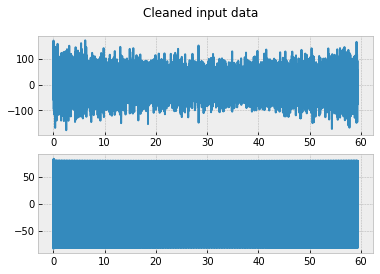

In [13]:
fig, ax = plt.subplots(len(meas_resample))
fig.suptitle('Cleaned input data')

for i, df_act in enumerate(cleaned):
    if len(meas_resample) == 1:
        ax.plot(df_act.index, df_act[plotChan.value])
    else:
        ax[i].plot(df_act.index, df_act[plotChan.value])
    plt.savefig('Running_statistics.png')


# 6. Rainflow Counting algorithm

The following cell creates two widgets
1. A Dropdown widget for asking which sensor data to plot 
2. A slider widget for asking number of bins

In [14]:
rfcChan = widgets.Dropdown(options = df_act.columns)
display(rfcChan)


binwidget = widgets.IntSlider(value = 64, min=1, max=1024, step=1,description='Bins:')
display(binwidget)

Dropdown(options=('sensor_1',), value='sensor_1')

IntSlider(value=64, description='Bins:', max=1024, min=1)

The following cell implements the rainflow counting algorithm on the dataset specified above(The sensor data chosen)
1. RainflowCounterFKM() processes the sample chunk and returns the from and to position of the closed hystersis loop on the sample 
2. get_rainflow_matrix_frame takes in no of bins as input and returns a dataframe which contains bi-directional histogram values assigned to appropriate bin indices


In [15]:
rainflow = []
rfc_box = []


for df_act in cleaned:
    rfc = RainflowCounterFKM().process(df_act[rfcChan.value].values)
    rfm = rfc.get_rainflow_matrix_frame(binwidget.value)
    rainflow.append(rfm)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(rainflow)

[                                                                                          0
from                                       to                                              
(-167.42884142891933, -162.29928460626917] (-166.55579867433514, -161.48016924672643]   0.0
                                           (-161.48016924672643, -156.4045398191177]    0.0
                                           (-156.4045398191177, -151.328910391509]      0.0
                                           (-151.328910391509, -146.2532809639003]      0.0
                                           (-146.2532809639003, -141.1776515362916]     0.0
                                           (-141.1776515362916, -136.1020221086829]     0.0
                                           (-136.1020221086829, -131.02639268107416]    0.0
                                           (-131.02639268107416, -125.95076325346545]   0.0
                                           (-125.95076325346545, -120.875133825

[[  0. -inf -inf ... -inf -inf -inf]
 [-inf -inf   0. ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 ...
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ... -inf -inf -inf]
 [-inf -inf -inf ...   0. -inf -inf]]


<ipython-input-16-404c067c0d29>:20: RuntimeWarning: divide by zero encountered in log10
  print(np.log10(counts))
<ipython-input-16-404c067c0d29>:24: RuntimeWarning: divide by zero encountered in log10
  pl = ax.imshow(np.log10(counts), extent=[froms.min(), froms.max(), tos.min(), tos.max()])


[[     -inf 0.             -inf ...      -inf      -inf      -inf]
 [3.1693805 0.             -inf ...      -inf      -inf      -inf]
 [0.             -inf      -inf ...      -inf      -inf      -inf]
 ...
 [     -inf      -inf      -inf ...      -inf      -inf      -inf]
 [     -inf      -inf      -inf ...      -inf      -inf 0.       ]
 [     -inf      -inf      -inf ... 0.        3.1708482      -inf]]


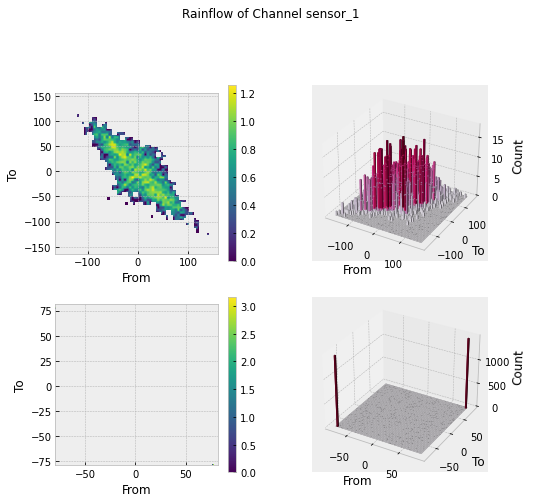

In [16]:
colormap = cm.ScalarMappable()
cmap = cm.get_cmap('PuRd')

fig = plt.figure(figsize = (8,11))                     # Plot of size 8*11
fig.suptitle('Rainflow of Channel ' + rfcChan.value) 


for i, rf_act in enumerate(rainflow):
    
    
    # 2D Plot 
    
    ax = fig.add_subplot(3,2,2*(i+1)-1)                # Subplot -- Grid parameters (3*2 grid, subplot index) 
    froms = rf_act.index.get_level_values('from').mid  # Accesses 'from' indices and gets mid value
    tos = rf_act.index.get_level_values('to').mid      # Accesses 'to' indices and gets mid value
    
    # Gets the shape of the dataset(histogram) and reshapes the values of the dataset into a 2D array #
    # Flip function - To plot increasing order (from bottom of the plot)
    counts = np.flipud((rf_act.values.reshape(rf_act.index.levshape).T))#.ravel()
    print(np.log10(counts))
    
    ax.set_xlabel('From')
    ax.set_ylabel('To')
    pl = ax.imshow(np.log10(counts), extent=[froms.min(), froms.max(), tos.min(), tos.max()])
    fig.colorbar(pl)
  
    
    
    # 3D Plot
    
    ax = fig.add_subplot(3,2,2*(i+1), projection='3d')          # For 3D subplots
    bottom = np.zeros_like(counts.ravel())
    
    # Gets the ranges of all the from and to indices(length) and finds out the minimum one #
    width = rf_act.index.get_level_values('from').length.min()
    depth = rf_act.index.get_level_values('to').length.min()    # For setting width and depth(minimum value)nof the bar graph 
    
    
    max_height = np.max(counts.ravel())   # get range of colorbars
    min_height = np.min(counts.ravel())
    rgba = [cmap((k-min_height)/max_height) for k in counts.ravel()]
    
    
    ax.set_xlabel('From')
    ax.set_ylabel('To')
    ax.set_zlabel('Count')
    pl3= ax.bar3d(froms.ravel(), tos.ravel(), bottom, width, depth, counts.ravel(), shade=True, color=rgba, zsort='average')
    plt.savefig('Rainflow.png')

# 7. Meanstress transformation

Creates widget for asking user input of the required slope values and the stress ratio (R_Goal)

In [17]:
meanstress_para = ['M', 'M2', 'R_Goal']
values = [0.3,0.2,-1]
child = [widgets.FloatText(description=name) for name in meanstress_para]
tab_mean = widgets.Tab()
tab_mean.children = child
for i in range(len(child)):
    tab_mean.set_title(i, meanstress_para[i])
    tab_mean.children[i].value = values[i]

tab_mean

The following cell does means stress transformation on the stress cycle and transforms to an equivalent stress cycle with zero mean stress

In [18]:
transformed = []
for rf_act in rainflow:
    transformed.append(rf_act.meanstress_hist.FKM_goodman(pd.Series({'M': tab_mean.children[0].value,
                                                                     'M2': tab_mean.children[1].value})
                                                          , R_goal = tab_mean.children[2].value))
    
transformed

[                                          frequency
 range                                              
 (0.0, 5.170967913299126]                        257
 (5.170967913299126, 10.341935826598252]         169
 (10.341935826598252, 15.512903739897379]        188
 (15.512903739897379, 20.683871653196505]        207
 (20.683871653196505, 25.85483956649563]         172
 ...                                             ...
 (294.7451710580502, 299.9161389713493]            2
 (299.9161389713493, 305.08710688464845]           1
 (305.08710688464845, 310.2580747979476]           1
 (310.2580747979476, 315.4290427112467]            0
 (315.4290427112467, 320.6000106245458]            1
 
 [62 rows x 1 columns],
                                           frequency
 range                                              
 (0.0, 2.5766306356403064]                         0
 (2.5766306356403064, 5.153261271280613]           0
 (5.153261271280613, 7.729891906920919]            0
 (7.729891906920919,

In [19]:
child = [widgets.FloatText(description=name) for name in files]
tab_repeat = widgets.Tab()
tab_repeat.children = child
for i in range(len(child)):
    tab_repeat.set_title(i, files[i])
    tab_repeat.children[i].value = int(50/(i+1))

tab_repeat


In [20]:

for ii in range(len(files)):
    transformed[ii] = transformed[ii]*tab_repeat.children[ii].value
    
range_only_total = combine_hist(transformed,method = "sum")
display(range_only_total)   


frequency
range                                              
(0.0, 5.009375166008528]                    12850.0
(5.009375166008528, 10.018750332017056]      8450.0
(10.018750332017056, 15.028125498025585]     9400.0
(15.028125498025585, 20.037500664034113]    10350.0
(20.037500664034113, 25.04687583004264]      8600.0
...                                             ...
(295.55313479450314, 300.5625099605117]       100.0
(300.5625099605117, 305.5718851265202]         50.0
(305.5718851265202, 310.5812602925287]         50.0
(310.5812602925287, 315.5906354585373]          0.0
(315.5906354585373, 320.6000106245458]         50.0

[64 rows x 1 columns]

The following cell plots the data for whole dataset and for the datas from different sensors (wn, sine) in the following manner  

                  I) Amplitude vs Cycles(Frequency)
                 II) Amplitude vs Cumulative sum of the cycles

array([5.0e+01, 7.4e+04, 5.0e+01, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00,
       0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00, 0.0e+00])

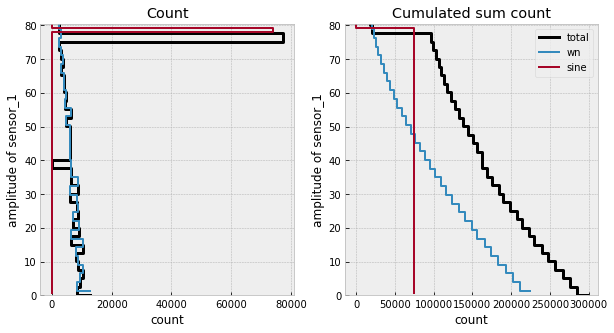

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(10, 5))
amplitude = range_only_total.index.get_level_values('range').left.values[::-1]/2
cycles = range_only_total.values[::-1].ravel()


ax[0].step(cycles,amplitude,c = "black",linewidth = 3, label = "total")
ax[1].step(np.cumsum(cycles),amplitude,c = "black",linewidth = 3, label = "total")
ii=0
for range_only in transformed:
    amplitude = range_only.index.get_level_values('range').mid.values[::-1]/2
    cycles = range_only.values[::-1].ravel()
    ax[0].step(cycles,amplitude,label = files [ii])
    ax[1].step(np.cumsum(cycles),amplitude,label = files [ii])
    ii += 1
ax[0].set_title('Count')
ax[1].set_title('Cumulated sum count')
ax[1].legend()

for ai in ax:
    ai.xaxis.grid(True)
    ai.set_xlabel('count')
    ai.set_ylabel('amplitude of ' + rfcChan.value)
    ai.set_ylim((0,max(amplitude)))
    plt.savefig('Meanstress.png')
    
amplitude
cycles

# 8. Material Parameters

The following cell creates a pandas data set for the material parameters to be utilized using pd.series function

In [22]:
mat = pd.Series(index = ['k_1', 'ND_50', 'SD_50', '1/TN', '1/TS'],
                data = [8, 1.5e+06, 1.5e+02, 12, 1.1])
display(mat)

k_1            8.0
ND_50    1500000.0
SD_50        150.0
1/TN          12.0
1/TS           1.1
dtype: float64

# 9. Damage calculation

In [23]:
SNmethod = widgets.Dropdown(options = ['Miner Elementar','Miner Haibach','Miner original'])
display(SNmethod)

Dropdown(options=('Miner Elementar', 'Miner Haibach', 'Miner original'), value='Miner Elementar')

In [24]:
damage_calc = sn_curve.FiniteLifeCurve(**mat.drop(['1/TN','1/TS']))
damage = damage_calc.calc_damage(range_only_total,method = 'original')

print("\033[5m  Total Damage of channel %s: %.2e  \033[0m" % (rfcChan.value,damage.sum()))

2021-03-26 19:26:07,357 - pylife.strength.sn_curve - WARNING - Using all cycles



  Total Damage of channel sensor_1: 3.54e-01  


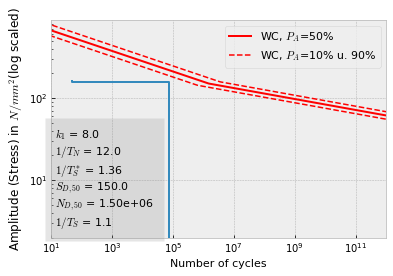

In [25]:
SRI = mat['SD_50']*(mat['ND_50']**(1/mat['k_1']))
# Plotting
diagdata = WoehlerCurveDiagrams(mat, fatigue_data = None, analyzer = None,
                                y_min=2, y_max=SRI, x_min=1e1, x_max=1e12, ax = None)
diagdata.plot_fitted_curve( k_2=15)
plt.step(np.cumsum(cycles),2*amplitude)
plt.savefig('Damage_SN.png')

# 10. Local Stress Approach

# FE based propability calculation

The following cell reads a hdf file which contains dataset of each node like stress tensor components, coordinates etc., And then it computes vonmises stress of each element using equistress.mises function.

In [50]:

filename = 'Data.xlsx'

stress = pd.read_excel(filename)
stress.sort_values(by=['element_id'], inplace= True)
display(stress)



""" Equivalent stress """

s_vm = stress.groupby('element_id').mean().equistress.mises().rename(columns={'mises': 'sigma_a'})
s_vm = 2*s_vm/s_vm.max()
display(s_vm)


""" Scale with """
ampl_fe = pd.DataFrame(data = amplitude, columns = ["ampl"] ,index =cycles)
display(ampl_fe)
s_vm_scaled = pd.DataFrame(data = ampl_fe.values*s_vm.transpose().values,index = ampl_fe.index,columns = s_vm.index)
display(s_vm_scaled)


node_id  element_id          x          y    z       S11       S22  S33  \
78      78.0         1.0  4000000.0  2500000.0  0.0  0.121543  1.287751  0.0   
180    180.0         1.0  3739174.0  2474418.0  0.0 -0.094991  0.398307  0.0   
81      81.0         1.0  4076120.0  2882683.0  0.0 -0.177036  0.784412  0.0   
97      97.0         1.0  3762995.0  2986873.0  0.0 -0.432368  0.303299  0.0   
95      95.0         2.0  4102013.0  3360908.0  0.0 -0.972344  0.113765  0.0   
..       ...         ...        ...        ...  ...       ...       ...  ...   
5        5.0       304.0  1200000.0        0.0  0.0 -1.080058 -0.002860  0.0   
4        4.0       305.0   800000.0        0.0  0.0 -1.068910 -0.015131  0.0   
3        3.0       306.0   400000.0        0.0  0.0 -1.202002 -0.037334  0.0   
1        1.0       307.0        0.0        0.0  0.0 -1.466051 -0.483797  0.0   
0        NaN         NaN        NaN        NaN  NaN       NaN       NaN  NaN   

          S12  S23  S13  
78  -0.033111  0.0  0.0  
180  0.007382  0.0  0.0  
81  -0.011142  0.0  0.0  
97  -0.214925  0.0  0.0  
95  -0.298710  0.0  0.0  
..        ...  ...  ...  
5    0.011375  0.0  0.0  
4   -0.008736  0.0  0.0  
3   -0.102140  0.0  0.0  
1   -0.305723  0.0  0.0  
0         NaN  NaN  NaN  

[353 rows x 11 columns]

sigma_a
element_id          
1.0         0.471123
2.0         0.726292
3.0         0.714047
4.0         0.796608
5.0         0.620596
...              ...
303.0       0.685309
304.0       0.648086
305.0       0.637707
306.0       0.719041
307.0       0.839856

[297 rows x 1 columns]

ampl
50.0     80.519707
74000.0  79.231392
50.0     77.943077
0.0      76.654761
0.0      75.366446
...            ...
0.0       5.797419
0.0       4.509104
0.0       3.220788
0.0       1.932473
0.0       0.644158

[63 rows x 1 columns]

element_id      1.0        2.0        3.0        4.0        5.0        6.0    \
50.0        37.934668  58.480835  57.494819  64.142613  49.970213  63.322477   
74000.0     37.327714  57.545141  56.574902  63.116331  49.170690  62.309318   
50.0        36.720759  56.609448  55.654985  62.090049  48.371166  61.296158   
0.0         36.113804  55.673755  54.735067  61.063768  47.571643  60.282998   
0.0         35.506849  54.738061  53.815150  60.037486  46.772119  59.269839   
...               ...        ...        ...        ...        ...        ...   
0.0          2.731296   4.210620   4.139627   4.618268   3.597855   4.559218   
0.0          2.124341   3.274927   3.219710   3.591986   2.798332   3.546059   
0.0          1.517387   2.339233   2.299793   2.565705   1.998809   2.532899   
0.0          0.910432   1.403540   1.379876   1.539423   1.199285   1.519739   
0.0          0.303477   0.467847   0.459959   0.513141   0.399762   0.506580   

element_id      7.0        8.0        9.0         10.0   ...      298.0  \
50.0        72.851112  78.871880  84.285488  131.361963  ...  66.259260   
74000.0     71.685494  77.609930  82.936921  129.260172  ...  65.199112   
50.0        70.519876  76.347980  81.588353  127.158380  ...  64.138964   
0.0         69.354258  75.086030  80.239785  125.056589  ...  63.078815   
0.0         68.188640  73.824080  78.891217  122.954798  ...  62.018667   
...               ...        ...        ...         ...  ...        ...   
0.0          5.245280   5.678775   6.068555    9.458061  ...   4.770667   
0.0          4.079662   4.416825   4.719987    7.356270  ...   3.710519   
0.0          2.914044   3.154875   3.371420    5.254479  ...   2.650370   
0.0          1.748427   1.892925   2.022852    3.152687  ...   1.590222   
0.0          0.582809   0.630975   0.674284    1.050896  ...   0.530074   

element_id      299.0      300.0      301.0      302.0      303.0      304.0  \
50.0        68.820139  67.391088  63.652462  59.229039  55.180893  52.183702   
74000.0     67.719017  66.312831  62.634022  58.281375  54.297999  51.348763   
50.0        66.617894  65.234574  61.615583  57.333710  53.415105  50.513824   
0.0         65.516772  64.156316  60.597143  56.386045  52.532211  49.678885   
0.0         64.415650  63.078059  59.578704  55.438381  51.649316  48.843945   
...               ...        ...        ...        ...        ...        ...   
0.0          4.955050   4.852158   4.582977   4.264491   3.973024   3.757227   
0.0          3.853928   3.773901   3.564538   3.316826   3.090130   2.922287   
0.0          2.752806   2.695644   2.546098   2.369162   2.207236   2.087348   
0.0          1.651683   1.617386   1.527659   1.421497   1.324341   1.252409   
0.0          0.550561   0.539129   0.509220   0.473832   0.441447   0.417470   

element_id      305.0      306.0      307.0  
50.0        51.347979  57.896974  67.624943  
74000.0     50.526411  56.970623  66.542944  
50.0        49.704844  56.044271  65.460945  
0.0         48.883276  55.117920  64.378946  
0.0         48.061708  54.191568  63.296947  
...               ...        ...        ...  
0.0          3.697054   4.168582   4.868996  
0.0          2.875487   3.242231   3.786997  
0.0          2.053919   2.315879   2.704998  
0.0          1.232351   1.389527   1.622999  
0.0          0.410784   0.463176   0.541000  

[63 rows x 297 columns]

## Damage Calculation

The following cell calculates the number of cycles to falure for a given stress amplitude

In [51]:
N = damage_calc.calc_N(s_vm_scaled,ignore_limits = True)
print(N)

2021-03-26 19:39:55,046 - pylife.strength.sn_curve - WARNING - Using all cycles



element_id         1.0           2.0           3.0           4.0    \
50.0        8.964602e+10  2.810042e+09  3.219524e+09  1.341678e+09   
74000.0     1.019930e+11  3.197069e+09  3.662949e+09  1.526467e+09   
50.0        1.162862e+11  3.645104e+09  4.176272e+09  1.740385e+09   
0.0         1.328726e+11  4.165021e+09  4.771952e+09  1.988623e+09   
0.0         1.521683e+11  4.769865e+09  5.464933e+09  2.277411e+09   
...                  ...           ...           ...           ...   
0.0         1.241284e+20  3.890925e+18  4.457914e+18  1.857754e+18   
0.0         9.268870e+20  2.905418e+19  3.328798e+19  1.387215e+19   
0.0         1.367890e+22  4.287784e+20  4.912604e+20  2.047237e+20   
0.0         8.144062e+23  2.552836e+22  2.924837e+22  1.218872e+22   
0.0         5.343319e+27  1.674916e+26  1.918986e+26  7.997021e+25   

element_id         5.0           6.0           7.0           8.0    \
50.0        9.888530e+09  1.487162e+09  4.845425e+08  2.567106e+08   
74000.0     1.12504

In [52]:
d_mesh_cycle =  1/(N.div(N.index.values, axis = 'index'))
print(d_mesh_cycle)

element_id         1.0           2.0           3.0           4.0    \
50.0        5.577493e-10  1.779333e-08  1.553025e-08  3.726678e-08   
74000.0     7.255402e-07  2.314620e-05  2.020230e-05  4.847796e-05   
50.0        4.299737e-10  1.371703e-08  1.197240e-08  2.872928e-08   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
0.0         0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

element_id         5.0           6.0           7.0           8.0    \
50.0        5.056363e-09  3.362109e-08  1.031901e-07  1.947719e-07   
74000.0     6.57749

In [53]:
display(d_mesh_cycle.max())

element_id
1.0      7.255402e-07
2.0      2.314620e-05
3.0      2.020230e-05
4.0      4.847796e-05
5.0      6.577499e-06
             ...     
303.0    1.454390e-05
304.0    9.303584e-06
305.0    8.176322e-06
306.0    2.136083e-05
307.0    7.399911e-05
Length: 297, dtype: float64

In [54]:
d_mesh = d_mesh_cycle.sum()
d_mesh


element_id
1.0      7.265280e-07
2.0      2.317771e-05
3.0      2.022980e-05
4.0      4.854396e-05
5.0      6.586453e-06
             ...     
303.0    1.456370e-05
304.0    9.316249e-06
305.0    8.187453e-06
306.0    2.138991e-05
307.0    7.409985e-05
Length: 297, dtype: float64

AttributeError: A mesh needs a pd.MultiIndex with the names `element_id` and `node_id`

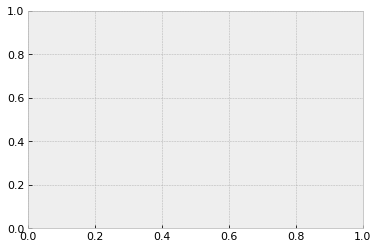

In [56]:
fig, ax = plt.subplots()
stress.join(pd.DataFrame(data = d_mesh,columns = ['d'])).meshplot.plot(ax, 'd', cmap='jet')
plt.title("Damage per element")
plt.show()
plt.savefig('Damage_plate.png')


# 11. Wöhler analyzing tool

## Initialization

In [31]:
import numpy as np
import pandas as pd
from os import path
import sys, os
import json

import pylife.materialdata.woehler as woehler
import pylife.utils.diagrams.probability_data as probdiagram
from pylife.materialdata.woehler.controls.data_file_display import DataFileDisplay
from pylife.materialdata.woehler.controls.woehler_curve_analyzer_options import  WoehlerCurveAnalyzerOptions
from pylife.materialdata.woehler.controls.woehler_curve_data_plotter import  WoehlerCurveDataPlotter
from pylife.materialdata.woehler.controls.whole_woehler_curve_plotter import  WholeWoehlerCurvePlotter
from pylife.materialdata.woehler.diagrams.woehler_curve_diagrams import WoehlerCurveDiagrams


In [32]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display
import warnings
import pdb

##  Data import

Data is made up of two columns:
* The first column is made up of the load values
* The second column is made up of the load-cycle values

In [33]:
file_name = 'woehler-test-data.csv'


## Transforming data in csv to python arrays

In [34]:
data = pd.read_csv(file_name, sep='\t')
data.columns=['load', 'cycles']
data

load    cycles
0   284.39285   1369000
1   284.39285  10000000
2   284.39285  10000000
3   284.39285  10000000
4   284.39285  10000000
5   294.19950    411000
6   294.19950  10000000
7   294.19950  10000000
8   294.19950  10000000
9   294.19950   2295000
10  304.00615    570000
11  304.00615   7868000
12  304.00615   1745000
13  304.00615  10000000
14  304.00615    502000
15  313.81280    727000
16  313.81280    231000
17  313.81280   1826000
18  313.81280   1943000
19  313.81280    413000
20  323.61945   1842000
21  323.61945   2200000
22  323.61945    166000
23  323.61945    312000
24  323.61945    981000
25  333.42610    397000
26  333.42610    532000
27  333.42610    326000
28  333.42610    146000
29  333.42610    763000

In [35]:
ld_cyc_lim = None
data = woehler.determine_fractures(data, ld_cyc_lim)
data

load    cycles  fracture
0   284.39285   1369000      True
1   284.39285  10000000     False
2   284.39285  10000000     False
3   284.39285  10000000     False
4   284.39285  10000000     False
5   294.19950    411000      True
6   294.19950  10000000     False
7   294.19950  10000000     False
8   294.19950  10000000     False
9   294.19950   2295000      True
10  304.00615    570000      True
11  304.00615   7868000      True
12  304.00615   1745000      True
13  304.00615  10000000     False
14  304.00615    502000      True
15  313.81280    727000      True
16  313.81280    231000      True
17  313.81280   1826000      True
18  313.81280   1943000      True
19  313.81280    413000      True
20  323.61945   1842000      True
21  323.61945   2200000      True
22  323.61945    166000      True
23  323.61945    312000      True
24  323.61945    981000      True
25  333.42610    397000      True
26  333.42610    532000      True
27  333.42610    326000      True
28  333.42610    146000      True
29  333.42610    763000      True

In [36]:
fatigue_data = data.fatigue_data
display(fatigue_data)

In [37]:
woehler_curve_analyzer_options = WoehlerCurveAnalyzerOptions(fatigue_data)

RadioButtons(description='Select method', options=('Maximum likelihood 2 params', 'Maximum likelihood 5 params…

k_1      8.626165e+00
ND_50    1.326971e+06
SD_50    2.952540e+02
1/TN     1.205947e+01
1/TS     1.106812e+00
dtype: float64
BIC: 54.92940437923815


RadioButtons(description='Plot Type', options=('Only initial data', 'Slope', 'Pearl chain', 'Deviation in load…

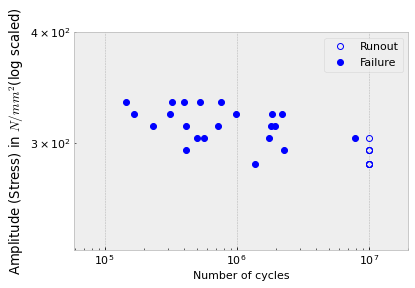

In [38]:
woehler_curve = woehler_curve_analyzer_options.woehler_curve
analyzer      = woehler_curve_analyzer_options.analyzer()
woehler_curve_data_plotter = WoehlerCurveDataPlotter(woehler_curve, fatigue_data, analyzer)

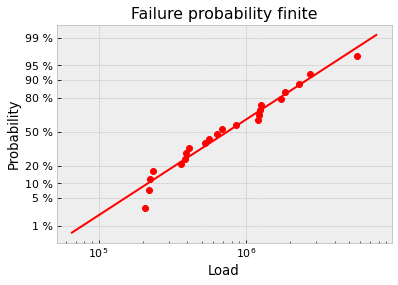

In [39]:
probdiag_finite = probdiagram.ProbabilityDataDiagram(analyzer.pearl_chain_estimator(),
                                                    occurrences_name='Load',
                                                    title='Failure probability finite')
probdiag_finite.plot()
if isinstance(analyzer, woehler.analyzers.probit.Probit):
    probdiag_infinite = probdiagram.ProbabilityDataDiagram(analyzer.pearl_chain_estimator(),
                                                        occurrences_name='Load',
                                                        title='Failure probability inffinite')
    probdiag_infinite.plot()

# Hotspot calculation demo

In [40]:
import numpy as np
import pylife
import pandas as pd
import scipy.stats as stats
import pylife.stress.equistress
import pylife.strength.meanstress
import pylife.mesh.meshplot
import pylife.mesh.hotspot
import matplotlib.pyplot as plt

In [58]:
filename = 'Data.xlsx'

fe_res = pd.read_excel(filename)
fe_res.sort_values(by=['element_id'], inplace= True)
fe_res(stress)

node_id  element_id          x          y    z       S11       S22  S33  \
78      78.0         1.0  4000000.0  2500000.0  0.0  0.121543  1.287751  0.0   
180    180.0         1.0  3739174.0  2474418.0  0.0 -0.094991  0.398307  0.0   
81      81.0         1.0  4076120.0  2882683.0  0.0 -0.177036  0.784412  0.0   
97      97.0         1.0  3762995.0  2986873.0  0.0 -0.432368  0.303299  0.0   
95      95.0         2.0  4102013.0  3360908.0  0.0 -0.972344  0.113765  0.0   
..       ...         ...        ...        ...  ...       ...       ...  ...   
5        5.0       304.0  1200000.0        0.0  0.0 -1.080058 -0.002860  0.0   
4        4.0       305.0   800000.0        0.0  0.0 -1.068910 -0.015131  0.0   
3        3.0       306.0   400000.0        0.0  0.0 -1.202002 -0.037334  0.0   
1        1.0       307.0        0.0        0.0  0.0 -1.466051 -0.483797  0.0   
0        NaN         NaN        NaN        NaN  NaN       NaN       NaN  NaN   

          S12  S23  S13  
78  -0.033111  0.0  0.0  
180  0.007382  0.0  0.0  
81  -0.011142  0.0  0.0  
97  -0.214925  0.0  0.0  
95  -0.298710  0.0  0.0  
..        ...  ...  ...  
5    0.011375  0.0  0.0  
4   -0.008736  0.0  0.0  
3   -0.102140  0.0  0.0  
1   -0.305723  0.0  0.0  
0         NaN  NaN  NaN  

[353 rows x 11 columns]

In [42]:
fe_res["vM"] = pylife.stress.equistress.mises(fe_res["S11"],fe_res["S22"],fe_res["S33"],fe_res["S12"],fe_res["S13"],fe_res["S23"])
display(fe_res["vM"].sort_values(ascending = False))

node_id  element_id
5        456           287.099222
9        2852          270.115389
6433     456           260.993366
11217    2852          243.603037
119      456           236.079927
                          ...    
491      3933            1.218400
8021     1437            0.874036
6470     470             0.819183
306      2538            0.472104
         2525            0.436058
Name: vM, Length: 37884, dtype: float64

In [43]:
display(fe_res)

E11       E22  E33       E12  PE11  PE22  PE33  PE12  \
node_id element_id                                                              
1734    1           0.000119 -0.000006  0.0 -0.000169   0.0   0.0   0.0   0.0   
1582    1           0.000133 -0.000035  0.0 -0.000133   0.0   0.0   0.0   0.0   
1596    1           0.000219 -0.000042  0.0 -0.000221   0.0   0.0   0.0   0.0   
4923    1           0.000126 -0.000020  0.0 -0.000151   0.0   0.0   0.0   0.0   
4924    1           0.000176 -0.000038  0.0 -0.000177   0.0   0.0   0.0   0.0   
...                      ...       ...  ...       ...   ...   ...   ...   ...   
3812    4770        0.000170 -0.000040  0.0 -0.000182   0.0   0.0   0.0   0.0   
12418   4770        0.000152 -0.000031  0.0 -0.000177   0.0   0.0   0.0   0.0   
14446   4770        0.000158 -0.000032  0.0 -0.000171   0.0   0.0   0.0   0.0   
14614   4770        0.000168 -0.000038  0.0 -0.000171   0.0   0.0   0.0   0.0   
14534   4770        0.000157 -0.000035  0.0 -0.000181   0.0   0.0   0.0   0.0   

                          S11       S22  S33        S12          x         y  \
node_id element_id                                                             
1734    1           27.080811  6.927080  0.0 -13.687358  14.897208  5.269875   
1582    1           28.319006  1.178649  0.0 -10.732705  14.555333  5.355806   
1596    1           47.701195  5.512213  0.0 -17.866833  14.630658  4.908741   
4923    1           27.699907  4.052865  0.0 -12.210032  14.726271  5.312840   
4924    1           38.010101  3.345431  0.0 -14.299768  14.592996  5.132274   
...                       ...       ...  ...        ...        ...       ...   
3812    4770        36.527439  2.470588  0.0 -14.706686 -13.189782 -5.691876   
12418   4770        32.868889  3.320898  0.0 -14.260107 -13.560289 -5.278386   
14446   4770        34.291058  3.642457  0.0 -13.836027 -13.673285 -5.569107   
14614   4770        36.063541  2.828889  0.0 -13.774759 -13.389065 -5.709927   
14534   4770        33.804211  2.829817  0.0 -14.580153 -13.276068 -5.419206   

                      z  S13  S23         vM  
node_id element_id                            
1734    1           0.0  0.0  0.0  33.996987  
1582    1           0.0  0.0  0.0  33.399850  
1596    1           0.0  0.0  0.0  54.777007  
4923    1           0.0  0.0  0.0  33.446991  
4924    1           0.0  0.0  0.0  44.070962  
...                 ...  ...  ...        ...  
3812    4770        0.0  0.0  0.0  43.577209  
12418   4770        0.0  0.0  0.0  39.903508  
14446   4770        0.0  0.0  0.0  40.478974  
14614   4770        0.0  0.0  0.0  42.140169  
14534   4770        0.0  0.0  0.0  41.143837  

[37884 rows x 18 columns]

In [44]:
threshold = .5 # factor of the maximum local value
fe_res['hotspot'] = fe_res.hotspot.calc("vM", threshold)
display(fe_res[['x', 'y', 'z', 'vM', 'hotspot']])

x         y    z         vM  hotspot
node_id element_id                                              
1734    1           14.897208  5.269875  0.0  33.996987        0
1582    1           14.555333  5.355806  0.0  33.399850        0
1596    1           14.630658  4.908741  0.0  54.777007        0
4923    1           14.726271  5.312840  0.0  33.446991        0
4924    1           14.592996  5.132274  0.0  44.070962        0
...                       ...       ...  ...        ...      ...
3812    4770       -13.189782 -5.691876  0.0  43.577209        0
12418   4770       -13.560289 -5.278386  0.0  39.903508        0
14446   4770       -13.673285 -5.569107  0.0  40.478974        0
14614   4770       -13.389065 -5.709927  0.0  42.140169        0
14534   4770       -13.276068 -5.419206  0.0  41.143837        0

[37884 rows x 5 columns]

In [45]:
display(fe_res["hotspot"].sort_values(ascending = False))

node_id  element_id
3062     2453          4
13021    3768          3
3904     3762          3
3918     3967          3
4017     3767          3
                      ..
10299    3145          0
10281    3145          0
10305    3145          0
3333     3145          0
1734     1             0
Name: hotspot, Length: 37884, dtype: int64

In [46]:
fe_res['hotspot'].max()

4

NameError: name 'fe_res' is not defined

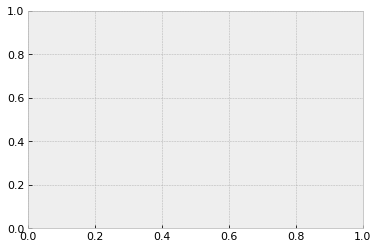

In [57]:
fig, ax = plt.subplots()
fe_res.meshplot.plot(ax, 'hotspot', cmap='jet')
plt.show()